## **Medical Report Summarisation using Medical Knowledge**

### **References**

**Main Reference**
- Radiology report generation with medical knowledge and multilevel image-report alignment: A new method and its verification
https://www.sciencedirect.com/science/article/pii/S0933365723002282#bib1



## **Data Collection**

### **Collect Datasets**

In [9]:
'''Libraries Installation and Import'''

# install necessary libraries
!pip install Pillow
!pip install torchvision
!pip install nltk
!pip install pyspellchecker
!pip install tqdm
!pip install opencv-python
!pip install transformers



# importing required libraries
import os
import re
import requests
import tarfile
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image
import cv2

import nltk
from nltk.corpus import stopwords
from spellchecker import SpellChecker

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms

from transformers import BertTokenizer, BertModel

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [10]:
'''Setup - Generalized'''

# setup to download the IU X-Ray Dataset
dataset = 'iu_xray/'
download_path = os.path.join('./datasets', dataset)

# from google.colab import drive
# drive.mount('/content/drive')
# download_path = os.path.join('/content/drive/Othercomputers/My Laptop/CS550_ASMT_MRSMK/datasets', dataset)
# download_path = os.path.join('/content/drive/MyDrive/Academics/CS550 Machine Learning/CS550 ASMT MRSMK/datasets', dataset)

images_dir = os.path.join(download_path, "images")
reports_dir = os.path.join(download_path, "reports")

images_url = "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz"
reports_url = "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz"


# function to check the file size of a given URL
def get_file_size(url):
    response = requests.head(url)
    size_in_bytes = int(response.headers.get('Content-Length', 0))
    size_in_mb = size_in_bytes / (1024 * 1024)
    return size_in_mb


# function to download and extract from a given url to a given directory
def download_and_extract(url, save_dir):
    file_name = url.split('/')[-1]
    file_path = os.path.join(save_dir, file_name)

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('Content-Length', 0))
    downloaded_size = 0

    with open(file_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
                downloaded_size += len(chunk)
                percent_complete = (downloaded_size / total_size) * 100
                print(f"Downloaded {downloaded_size / (1024*1024):.2f} MB out of {total_size / (1024*1024):.2f} MB: {percent_complete:.2f}% complete")

    print("\nDownload complete!")

    with tarfile.open(file_path, 'r:gz') as tar:
        members = tar.getmembers()
        total_files = len(members)

        for idx, member in enumerate(members, start=1):
            tar.extract(member, path=save_dir)
            print(f"Extracting File {idx} out of {total_files}: {member.name}")

    os.remove(file_path)


# downloading  IU X-Ray dataset
if not os.path.exists(images_dir):
    images_size = get_file_size(images_url)
    print(f"Downloading {images_url} to: {images_dir} ({images_size:.2f} MB)")
    os.makedirs(images_dir, exist_ok=True)
    download_and_extract(images_url, images_dir)
    print(f"Downloaded {images_url} to: {images_dir}")
else:
    print(f"{images_url} already exists at: {images_dir}")

if not os.path.exists(reports_dir):
    reports_size = get_file_size(reports_url)
    print(f"Downloading {reports_url} to: {reports_dir} ({reports_size:.2f} MB)")
    os.makedirs(reports_dir, exist_ok=True)
    download_and_extract(reports_url, reports_dir)
    print(f"Downloaded {reports_url} to: {reports_dir}")
else:
    print(f"{reports_url} already exists at: {reports_dir}")

https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz already exists at: ./datasets/iu_xray/images
https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz already exists at: ./datasets/iu_xray/reports


In [11]:
'''Exploring the IU X-Ray Dataset Contents'''

# displaying directory and subdirectory contents
iu_xray = download_path
print("\nPath: ", iu_xray)
print(f"Directory Contents: {os.listdir(iu_xray)}")

iu_xray_images = images_dir
print("\nPath: ", iu_xray_images)
print(f"Directory Contents: {len(os.listdir(iu_xray_images))} Images")

iu_xray_reports = os.path.join(reports_dir, 'ecgen-radiology')
print("\nPath: ", iu_xray_reports)
print(f"Directory Contents: {len(os.listdir(iu_xray_reports))} Reports")


Path:  ./datasets/iu_xray/
Directory Contents: ['images_preprocessed', 'reports', 'iu_xray_images_df.csv', 'iu_xray_reports_df.csv', 'iu_xray_data.csv', 'images']

Path:  ./datasets/iu_xray/images
Directory Contents: 7471 Images

Path:  ./datasets/iu_xray/reports/ecgen-radiology
Directory Contents: 3955 Reports


In [12]:
'''Processing Textual Data from each .xml Report File and Storing it in a .csv File'''

# function to iterate through all .xml report files and storing them in a dataframe
def save_images_df():
    data = []
    cnt = 0
    for file in os.listdir(iu_xray_reports):
        if file.endswith(".xml"):
            cnt += 1
            print(f"Processing .xml File {cnt} out of {len(os.listdir(iu_xray_reports))}: {file}")

            file_path = os.path.join(iu_xray_reports, file)
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()

                pmc_id = root.find('.//pmcId').attrib.get('id')

                comparison = indication = findings = impression = None

                for abstract in root.findall('.//AbstractText'):
                    if abstract.attrib.get('Label') == 'COMPARISON':
                        comparison = abstract.text
                    elif abstract.attrib.get('Label') == 'INDICATION':
                        indication = abstract.text
                    elif abstract.attrib.get('Label') == 'FINDINGS':
                        findings = abstract.text
                    elif abstract.attrib.get('Label') == 'IMPRESSION':
                        impression = abstract.text

                for parent_image in root.findall('parentImage'):
                    image_file = parent_image.attrib['id'] + ".png"
                    image_path = os.path.join(iu_xray_images, image_file)
                    image = cv2.imread(image_path)

                    if image is not None:
                        height, width, channels = image.shape
                        caption = parent_image.find('caption').text if parent_image.find('caption') is not None else None
                        data.append([pmc_id, image_file, caption, comparison, indication, findings, impression, height, width])
                    else:
                        print(f"Warning: Unable to read image {image_path}")

            except Exception as e:
                print(f"Error processing file {file}: {e}")

    return data


# create a dataframe and save it as csv
iu_xray_images_df_path = os.path.join(iu_xray, 'iu_xray_images_df.csv')
if not os.path.exists(iu_xray_images_df_path):
    data = save_images_df()
    columns = ['pmc_id', 'image_filename', 'caption', 'comparison', 'indication', 'findings', 'impression', 'height', 'width']
    iu_xray_images_df = pd.DataFrame(data, columns=columns)
    iu_xray_images_df.to_csv(iu_xray_images_df_path, index=False)
    print(f"Dataframe saved to {iu_xray_images_df_path}")
else:
    print(f"Dataframe already exists at {iu_xray_images_df_path}")
    iu_xray_images_df = pd.read_csv(iu_xray_images_df_path)


# display the stored dataframe
print("\n\nDataframe Shape:", iu_xray_images_df.shape)

print("\n\nDataframe Information:\n")
display(iu_xray_images_df.info())

print("\n\nDisplaying Dataframe:\n")
display(iu_xray_images_df.head())

Dataframe already exists at ./datasets/iu_xray/iu_xray_images_df.csv


Dataframe Shape: (7470, 9)


Dataframe Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7470 entries, 0 to 7469
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pmc_id          7470 non-null   int64 
 1   image_filename  7470 non-null   object
 2   caption         7468 non-null   object
 3   comparison      5210 non-null   object
 4   indication      7311 non-null   object
 5   findings        6473 non-null   object
 6   impression      7418 non-null   object
 7   height          7470 non-null   int64 
 8   width           7470 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 525.4+ KB


None



Displaying Dataframe:



,pmc_id,image_filename,caption,comparison,indication,findings,impression,height,width
0,779,CXR779_IM-2321-1001.png,"Radiographs of the chest, 2 views, dated XXXX,...","CT chest, dated XXXX, XXXX.",XXXX-year-old female. Pain after XXXX.,The cardiomediastinal silhouette is normal in ...,Negative for acute abnormality.,420,512
1,779,CXR779_IM-2321-2001.png,"Radiographs of the chest, 2 views, dated XXXX,...","CT chest, dated XXXX, XXXX.",XXXX-year-old female. Pain after XXXX.,The cardiomediastinal silhouette is normal in ...,Negative for acute abnormality.,624,512
2,1102,CXR1102_IM-0069-12012.png,"AP and lateral views of the chest dated XXXX, ...","XXXX, XXXX.",Shortness of breath. Unable to XXXX XXXX for l...,There is stable cardiomegaly with XXXX pulmona...,"1. Cardiomegaly, vascular congestion and proba...",420,512
3,1102,CXR1102_IM-0069-2001.png,"AP and lateral views of the chest dated XXXX, ...","XXXX, XXXX.",Shortness of breath. Unable to XXXX XXXX for l...,There is stable cardiomegaly with XXXX pulmona...,"1. Cardiomegaly, vascular congestion and proba...",512,512
4,1102,CXR1102_IM-0069-3001.png,"AP and lateral views of the chest dated XXXX, ...","XXXX, XXXX.",Shortness of breath. Unable to XXXX XXXX for l...,There is stable cardiomegaly with XXXX pulmona...,"1. Cardiomegaly, vascular congestion and proba...",512,512


In [13]:
'''Processing Textual Data from each .xml Report File and Storing it in a .csv File'''

# function to iterate through all .xml report files and storing them in a dataframe
def save_reports_df():
    data = []
    cnt = 0
    for file in os.listdir(iu_xray_reports):
        if file.endswith(".xml"):
            cnt += 1
            print(f"Processing .xml File {cnt} out of {len(os.listdir(iu_xray_reports))}: {file}")

            file_path = os.path.join(iu_xray_reports, file)
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()

                pmc_id = root.find('.//pmcId').attrib.get('id')

                comparison = indication = findings = impression = None

                for abstract in root.findall('.//AbstractText'):
                    if abstract.attrib.get('Label') == 'COMPARISON':
                        comparison = abstract.text
                    elif abstract.attrib.get('Label') == 'INDICATION':
                        indication = abstract.text
                    elif abstract.attrib.get('Label') == 'FINDINGS':
                        findings = abstract.text
                    elif abstract.attrib.get('Label') == 'IMPRESSION':
                        impression = abstract.text

                report_data = {
                    'pmc_id': pmc_id,
                    'findings': findings,
                    'impression': impression,
                    'comparison': comparison,
                    'indication': indication,
                }

                parent_images = root.findall('parentImage')
                report_data['image_count'] = len(parent_images)

                for i, parent_image in enumerate(parent_images, start=1):
                    image_file = parent_image.attrib['id'] + ".jpg"
                    caption = parent_image.find('caption').text if parent_image.find('caption') is not None else None
                    report_data[f'image_{i}'] = f"{image_file}: {caption}" if caption else image_file

                data.append(report_data)

            except Exception as e:
                print(f"Error processing file {file}: {e}")

    return data


# create a dataframe and save it as csv
iu_xray_reports_df_path = os.path.join(iu_xray, 'iu_xray_reports_df.csv')
if not os.path.exists(iu_xray_reports_df_path):
    data = save_reports_df()
    iu_xray_reports_df = pd.DataFrame(data)
    iu_xray_reports_df.to_csv(iu_xray_reports_df_path, index=False)
    print(f"Dataframe saved to {iu_xray_reports_df_path}")
else:
    print(f"Dataframe already exists at {iu_xray_reports_df_path}")
    iu_xray_reports_df = pd.read_csv(iu_xray_reports_df_path)


# display the stored dataframe
print("\n\nDataframe Shape:", iu_xray_reports_df.shape)

print("\n\nDataframe Information:\n")
display(iu_xray_reports_df.info())

print("\n\nDisplaying Dataframe:\n")
display(iu_xray_reports_df.head())

Dataframe already exists at ./datasets/iu_xray/iu_xray_reports_df.csv


Dataframe Shape: (3955, 6)


Dataframe Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3955 entries, 0 to 3954
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pmc_id      3955 non-null   int64 
 1   findings    3425 non-null   object
 2   impression  3921 non-null   object
 3   comparison  2757 non-null   object
 4   indication  3865 non-null   object
 5   images      3955 non-null   object
dtypes: int64(1), object(5)
memory usage: 185.5+ KB


None



Displaying Dataframe:



,pmc_id,findings,impression,comparison,indication,images
0,779,The cardiomediastinal silhouette is normal in ...,Negative for acute abnormality.,"CT chest, dated XXXX, XXXX.",XXXX-year-old female. Pain after XXXX.,{'CXR779_IM-2321-1001.jpg': 'Radiographs of th...
1,1102,There is stable cardiomegaly with XXXX pulmona...,"1. Cardiomegaly, vascular congestion and proba...","XXXX, XXXX.",Shortness of breath. Unable to XXXX XXXX for l...,{'CXR1102_IM-0069-12012.jpg': 'AP and lateral ...
2,1574,Lungs are clear bilaterally. Cardiac and media...,No acute cardiopulmonary abnormality.,"XXXX, XXXX.","Shortness of breath, wheezing, XXXX.",{'CXR1574_IM-0374-1001.jpg': 'PA and lateral c...
3,2833,"The heart, pulmonary XXXX and mediastinum are ...",No acute cardiopulmonary disease.,Two views of the chest dated XXXX.,XXXX-year-old male with XXXX's disease. Chroni...,{'CXR2833_IM-1249-1001.jpg': 'PA and lateral c...
4,3216,"Heart size is normal. No pneumothorax, pleural...",Normal chest radiograph.,None available.,XXXX-year-old female with dyspnea.,{'CXR3216_IM-1520-1001.jpg': 'Chest XXXX and l...


In [70]:
'''Displaying the Number of Images per Report'''

# displaying the distribution of number of images per report
reports_count = iu_xray_reports_df['image_count'].value_counts().rename_axis('images_qty').reset_index(name='reports_count')
print("\n\nNumber of Images per Report:\n")
display(reports_count)

KeyError: 'image_count'

## **Data Preprocessing**

### **Preprocess Images**

In [14]:
'''Preprocessing Images - Resizing, Tensor Conversion and Normalization'''

# function to preprocess and save images
def preprocess_images(input_dir, output_dir):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    ])

    os.makedirs(output_dir, exist_ok=True)

    cnt = 0
    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):
            cnt += 1
            print(f"Preprocessing File {cnt} out of {len(os.listdir(input_dir))}: {filename}")

            image_path = os.path.join(input_dir, filename)
            image = Image.open(image_path).convert('RGB')
            processed_image = preprocess(image)

            processed_image_path = os.path.join(output_dir, filename)

            processed_image_pil = transforms.ToPILImage()(processed_image)
            processed_image_pil.save(processed_image_path)


# preprocessing images
iu_xray_images_preprocessed = os.path.join(iu_xray, 'images_preprocessed')
if not os.path.exists(iu_xray_images_preprocessed):
    print(f"Preprocessing Images to: {iu_xray_images_preprocessed}")
    preprocess_images(iu_xray_images, iu_xray_images_preprocessed)
    print(f"Preprocessed Images saved to: {iu_xray_images_preprocessed}")
else:
    print(f"Preprocessed Images already exist at: {iu_xray_images_preprocessed}")

Preprocessed Images already exist at: ./datasets/iu_xray/images_preprocessed


### **Preprocess Text**

In [67]:
'''Preprocessing Text - Lowercasing, Decontracting, Punctuation Removal, Number Removal, Two-Letter Word Removal, Stop Word Removal, Negation Handling, Spell Checking, Extra Space Removal'''

# download nltk resources and initialize spell checker
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
spell = SpellChecker()


# function to convert text to lowercase
def lowercase(text):
    return text.lower() if isinstance(text, str) else text


# function to decontract words
def decontracted(text):
    if not isinstance(text, str):
        return text
    contractions = {
        "won't": "will not", "can't": "can not", "couldn't": "could not",
        "shouldn't": "should not", "wouldn't": "would not", "n't": " not",
        "'re": " are", "'s": " is", "'d": " would", "'ll": " will",
        "'t": " not", "'ve": " have", "'m": " am"
    }
    for contraction, full_form in contractions.items():
        text = text.replace(contraction, full_form)
    return text


# function to remove punctuations
def rem_punctuations(text):
    return re.sub(r'[^\w\s]', '', text) if isinstance(text, str) else text


# function to remove numbers
def rem_numbers(text):
    return re.sub(r'\d+', '', text) if isinstance(text, str) else text


# function to remove two-letter words except "no" and "ct"
def rem_two_letter_words(text):
    if not isinstance(text, str):
        return text
    return ' '.join(word for word in text.split() if len(word) > 2 or word in ["no", "ct"])


# function to remove stop words
def rem_stop_words(text):
    if not isinstance(text, str):
        return text
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in text.split() if word not in stop_words)


# function to handle negations
def handle_negations(text):
    if not isinstance(text, str):
        return text
    negations = {"no": "not", "not": "not"}
    return ' '.join(negations.get(word, word) for word in text.split())


# function to correct spelling
def correct_spelling(text):
    if not isinstance(text, str):
        return text
    corrected = []
    for word in text.split():
        corrected_word = list(spell.candidates(word))[0] if spell.candidates(word) else word
        corrected.append(corrected_word)
    return ' '.join(corrected)


# function to remove extra spaces
def rem_extra_spaces(text):
    return ' '.join(text.split()) if isinstance(text, str) else text


# function to preprocess text
def preprocess_text(data):
    preprocessed = []
    for sentence in tqdm(data.values):
        sentence = str(sentence)
        sentence = lowercase(sentence)
        sentence = decontracted(sentence)
        sentence = rem_punctuations(sentence)
        sentence = rem_numbers(sentence)
        sentence = rem_two_letter_words(sentence)
        sentence = rem_stop_words(sentence)
        sentence = handle_negations(sentence)
        sentence = correct_spelling(sentence)
        sentence = rem_extra_spaces(sentence)

        preprocessed.append(sentence)

    return preprocessed


# function to preprocess text and save the corresponding dataframe
def preprocess_and_save_dataframe(dataframe, path):
    columns_to_preprocess = {
        'caption': 'unknown',
        'comparison': 'no comparison',
        'indication': 'no indication',
        'findings': 'no findings',
        'impression': 'no impression'
    }

    for column, fill_value in columns_to_preprocess.items():
        if column in dataframe.columns:
            print(f"Preprocessing Column: {column}")
            dataframe.loc[:, column] = dataframe[column].fillna(fill_value).astype(str)
            dataframe.loc[:, column] = preprocess_text(dataframe[column])
            dataframe.to_csv(path, index=False)
            print(f"Preprocessed Dataframe Column {column} and saved Dataframe to: {path}")

    return dataframe


# save and display the preprocessed dataframe for reports
iu_xray_reports_preprocessed_df_path = os.path.join(iu_xray, 'iu_xray_reports_preprocessed_df.csv')
if not os.path.exists(iu_xray_reports_preprocessed_df_path):
    print(f"Preprocessing Text DataFrame {iu_xray_reports_df_path} to: {iu_xray_reports_preprocessed_df_path}")
    iu_xray_reports_preprocessed_df = preprocess_and_save_dataframe(iu_xray_reports_df, iu_xray_reports_preprocessed_df_path)
    print(f"Preprocessed Text DataFrame {iu_xray_reports_df_path} saved to: {iu_xray_reports_preprocessed_df_path}")
else:
    print(f"Preprocessed Text DataFrame {iu_xray_reports_df_path} already exists at: {iu_xray_reports_preprocessed_df_path}")
    iu_xray_reports_preprocessed_df = pd.read_csv(iu_xray_reports_preprocessed_df_path)
display(iu_xray_reports_preprocessed_df.head())

[nltk_data] Downloading package punkt to /home/shivangi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/shivangi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shivangi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing Text DataFrame ./datasets/iu_xray/iu_xray_reports_df.csv to: ./datasets/iu_xray/iu_xray_reports_preprocessed_df.csv
Preprocessing Column: comparison


  2%|▉                                        | 87/3955 [00:04<03:24, 18.91it/s]


KeyboardInterrupt: 

### **Create Data Loaders**

In [15]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Update your load_preprocessed_images function to use CustomImageDataset
def load_preprocessed_images(image_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resizing to fit the model input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = CustomImageDataset(image_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# Load images from preprocessed directory
image_dir = iu_xray_images_preprocessed
dataloader = load_preprocessed_images(image_dir)


## **Model Implementation**

### **Visual Extractor**

In [16]:
'''Visual Extractor to Extract Data from Image and Encode it Accordingly'''

# define device for gpu support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# define the visual extractor model using ResNet101 
class VisualExtractor(nn.Module):
    def __init__(self, args):
        super(VisualExtractor, self).__init__()
        self.visual_extractor = args.visual_extractor
        self.pretrained = args.visual_extractor_pretrained
        model = getattr(models, self.visual_extractor)(pretrained=self.pretrained)
        modules = list(model.children())[:-2]  
        self.model = nn.Sequential(*modules)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_layer = nn.Linear(model.fc.in_features, 2048) 
        
    def forward(self, images):
        patch_feats = self.model(images)
        avg_feats = self.avg_pool(patch_feats).squeeze() 
        avg_feats = self.fc_layer(avg_feats)

        batch_size, feat_size, _, _ = patch_feats.shape
        patch_feats = patch_feats.view(batch_size, feat_size, -1).permute(0, 2, 1)
        
        final_embedding = torch.cat((avg_feats.unsqueeze(1), patch_feats), dim=1) 
        
        return patch_feats, avg_feats, final_embedding


#arguments for the visual extractor
class Args:
    visual_extractor = 'resnet101' 
    visual_extractor_pretrained = True


#initializing the model
args = Args()
visual_extractor = VisualExtractor(args).to(device)

def load_preprocessed_images(preprocessed_image_dir, batch_size=32):
    dataset = datasets.ImageFolder(root=preprocessed_image_dir) 
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

def extract_features(dataloader):
    all_patch_feats = []
    all_avg_feats = []
    all_final_embeddings = []

    visual_extractor.eval() 
    with torch.no_grad():
        for images in tqdm(dataloader):
            patch_feats, avg_feats, final_embedding = visual_extractor(images)
            all_patch_feats.append(patch_feats.cpu()) 
            all_avg_feats.append(avg_feats.cpu())
            all_final_embeddings.append(final_embedding.cpu())

    all_patch_feats = torch.cat(all_patch_feats, dim=0)
    all_avg_feats = torch.cat(all_avg_feats, dim=0)
    all_final_embeddings = torch.cat(all_final_embeddings, dim=0)

    return all_patch_feats, all_avg_feats, all_final_embeddings

def save_features(file_path, features):
    print(f"Saving features to {file_path}")
    torch.save(features, file_path)

def load_features(file_path):
    if os.path.exists(file_path):
        print(f"Loading features from {file_path}")
        return torch.load(file_path)
    return None
feature_dir=iu_xray
patch_feats_file = os.path.join(feature_dir, 'patch_feats.pt')
avg_feats_file = os.path.join(feature_dir, 'avg_feats.pt')
final_embeddings_file = os.path.join(feature_dir, 'final_embeddings.pt')
if os.path.exists(patch_feats_file) and os.path.exists(avg_feats_file) and os.path.exists(final_embeddings_file):
    print("All features are already precomputed and will be loaded.")
    patch_feats = load_features(patch_feats_file)
    avg_feats = load_features(avg_feats_file)
    final_embeddings = load_features(final_embeddings_file)
else:
    print("Extracting features since they are not precomputed...")
    patch_feats, avg_feats, final_embeddings = extract_features(dataloader)  # Your extraction function
        
    # Save features
    os.makedirs(feature_dir, exist_ok=True)
    save_features(patch_feats_file, patch_feats)
    save_features(avg_feats_file, avg_feats)
    save_features(final_embeddings_file, final_embeddings)

# # extract features
# patch_feats, avg_feats, final_embeddings = extract_features(dataloader)


# patch_feats, avg_feats, and final_embeddings
print("Patch Features Shape:", patch_feats.shape)
print("Average Features Shape:", avg_feats.shape)
print("Final Embedding Shape:", final_embeddings.shape)


/home/shivangi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shivangi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features since they are not precomputed...


100%|█████████████████████████████████████████| 234/234 [10:12<00:00,  2.62s/it]


Saving features to ./datasets/iu_xray/patch_feats.pt
Saving features to ./datasets/iu_xray/avg_feats.pt
Saving features to ./datasets/iu_xray/final_embeddings.pt
Patch Features Shape: torch.Size([7470, 49, 2048])
Average Features Shape: torch.Size([7470, 2048])
Final Embedding Shape: torch.Size([7470, 50, 2048])


()

Original feature shape: (7470, 50, 2048)


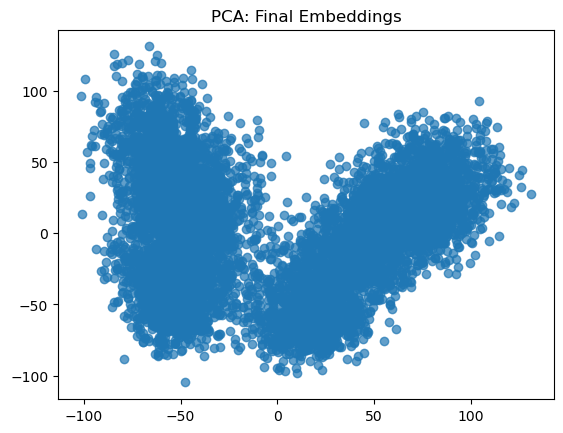

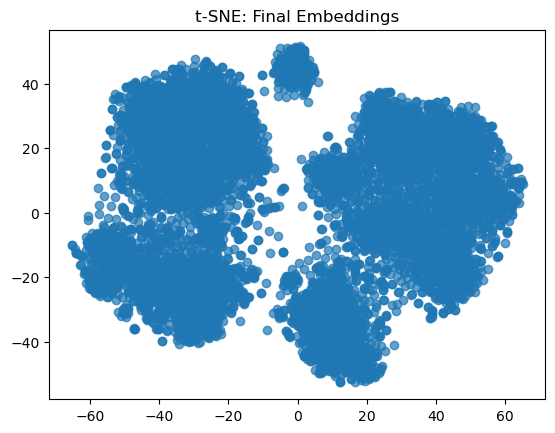

In [21]:
#VISUALIZATION OF EXTRACTED FEATURES USING PLOTS 

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_features(features, title):
    # Reduce dimensionality
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    # Reduce dimensionality
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(features)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    plt.title(f"PCA - {title}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

    plt.subplot(1, 2, 2)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
    plt.title(f"t-SNE - {title}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")

    plt.show()

    from sklearn.cluster import KMeans
    
    # K-Means Clustering
    num_clusters = 3
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(features)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title('t-SNE Result with K-Means Clusters')
    plt.colorbar()
    plt.show()
    plt.figure(figsize=(8, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title('PCA Result with K-Means Clusters')
    plt.colorbar()
    plt.show()

def visualize_features_2(features, title):
    # Check the shape of the features
    print(f"Original feature shape: {features.shape}")
    
    # Flatten the features to 2D (batch_size, -1)
    flattened_features = features.reshape(features.shape[0], -1)  # Flatten each image
    
    # Reduce dimensionality using PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(flattened_features)

    # Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(flattened_features)

    # Visualization
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    plt.title(f'PCA: {title}')
    plt.show()
    
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)
    plt.title(f't-SNE: {title}')
    plt.show()


# Visualize average features
#visualize_features(avg_feats.numpy(), "Average Features")
# You can also visualize patch features or final embeddings if needed
#visualize_features(patch_feats.numpy(), "Patch Features")
visualize_features_2(final_embeddings.numpy(), "Final Embeddings")

### **Text Encoder**

In [ ]:
'''Text Encoder - Encoding Dictionary, Encoding Medical History and Finding Cosine Similarity Between Them '''

# reading medical reports collected and ensuring all are strings
iu_xray_reports_preprocessed_df_path = os.path.join(download_path, 'iu_xray/iu_xray_reports_preprocessed_df.csv')
medical_history = pd.read_csv(iu_xray_reports_preprocessed_df_path)
medical_history = medical_history["findings"].dropna().tolist()  

medical_history = [str(report) for report in medical_history if isinstance(report, str) or pd.notna(report)]
if not medical_history:
    raise ValueError("No valid findings found in medical_history.")


# dictionary created with key as organ: chest
radiology_dictionary = {
    "chest": ["small", "enlarged", "unchanged", "stable", "silhouette", "contours", "size", "focal", "mild", "acute"]
}


# using pre-trained model to embed into numerical space
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


# function to embed text
def embed_text(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)


# embedding process
dictionary_embeddings = embed_text(radiology_dictionary["chest"] )
report_embeddings = embed_text(medical_history) 


# calculating cosine similarities
similarities = torch.mm(report_embeddings, dictionary_embeddings.T)


# finding top k relevant entries
k = 5
top_k_indices = similarities.topk(k=k, dim=1).indices
relevant_entries = [[dictionary_entries[idx] for idx in row] for row in top_k_indices]


# printing relevant entries of each report
for i, entries in enumerate(relevant_entries):
    print(f"Report {i+1}: Relevant Entries: {entries}")

### **Multilevel Alignment**

### **Report Generator**

### **Complete Model**

## **Training**

### **Training**

## **Testing**

### **Testing**